In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import getcwd
from os import listdir
from os.path import isfile, join, isdir

import skimage
from skimage import measure
from skimage import io

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K


import tensorflow as tf
import tflearn
from tflearn.data_utils import shuffle
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

In [21]:
def get_paths(foldNames):
  
    paths = dict.fromkeys(foldNames)

    for idx,g in enumerate(foldNames):
        fileNames = [f for f in listdir(join(trainPath,g)) if isfile(join(trainPath,g, f))]
        for i,f in enumerate(fileNames):
            fileNames[i] = join(trainPath,g,f)     
        paths[g] = fileNames
        
    return paths

def read_image(src):
    """Read and resize individual images"""
    im = io.imread(src)
    im = resize(im, (ROWS, COLS))
    return im


# Setup

In [22]:
ROWS = 9  #90 720
COLS = 16 #160 1280
CHANNELS = 3
trainPath = '../train'
testPath = '../test_stg1'
fish_classes = [f for f in listdir(trainPath) if isdir(join(trainPath, f))]
groupData = pd.DataFrame ({'group': fish_classes})
fish_paths = get_paths(fish_classes)

# Build x and y arrays

In [23]:
for idx,fish in enumerate(fish_classes):
    groupData.ix[idx,'num files'] = int(len(fish_paths[fish]))
    
files = []
Y_cat = []

for fish in fish_classes:
    fish_files = fish_paths[fish]
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    Y_cat.extend(y_fish)
  
Y_cat = np.array(Y_cat) 


In [24]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, f in enumerate(files): 
    im = read_image(f)
    X_all[i] = im
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))


Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777


# view resampled image

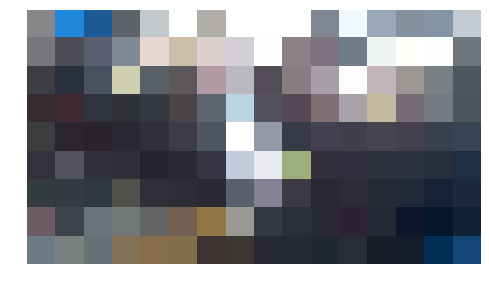

In [25]:
image = X_all[0]
plt.figure(figsize=(5, 5))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

# Training data
* One hot encoding labels
* Split data


In [26]:
# One Hot Encoding Labels
#    Transform the categorical array Y_all into matrix of the same height, 
#    but with a boolean column for each category.
Y_all = LabelEncoder().fit_transform(Y_cat)
Y_all = np_utils.to_categorical(Y_all)

# test_size: between 0 and 1. proportion of the dataset to include in the test split
# random_state: Pseudo-random number generator state used for random sampling. How to shoose this?
# stratify: this is ensuring that the split datasets are balanced, i.e. contains the same 
# percentage of classes

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=Y_all)

# Keras model
using this example:
https://www.kaggle.com/jeffd23/the-nature-conservancy-fisheries-monitoring/deep-learning-in-the-deep-blue-lb-1-279

In [27]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)


model = Sequential()
model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(fish_classes)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, Y_train, batch_size=64, nb_epoch=1,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 2416 samples, validate on 605 samples
Epoch 1/1
2416/2416 [==============================] - 5s - loss: 1.9711 - val_loss: 1.8249


In [29]:
preds = model.predict(X_valid, verbose=1)
print("Validation Log Loss: {}".format(log_loss(Y_valid, preds)))

756/756 [==============================] - 0s     
Validation Log Loss: 1.78604752819


In [30]:
# read in test photo set
test_files = [im for im in os.listdir(testPath)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(test_files): 
    test[i] = read_image(join(testPath,im))
    
#model predict
test_preds = model.predict(test, verbose=1)

 992/1000 [============================>.] - ETA: 0s

In [31]:
submission = pd.DataFrame(test_preds, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.718651,0.394385,0.563580,0.354318,0.476741,0.421754,0.278019,0.578045
1,img_00007.jpg,0.828790,0.329407,0.590444,0.265877,0.462128,0.377150,0.162928,0.624663
2,img_00009.jpg,0.828522,0.329704,0.589665,0.266147,0.462324,0.377669,0.163119,0.624307
3,img_00018.jpg,0.858445,0.308022,0.598143,0.238534,0.457815,0.362104,0.132853,0.640205
4,img_00027.jpg,0.838145,0.319167,0.614553,0.258414,0.458660,0.362617,0.157700,0.636650


# TFLEARN

In [ ]:
mkdir '../tflearn'

In [32]:
def dnn_test1():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    with tf.Graph().as_default():
        
        #input layer with shape of data specified. In this case, dimensions of our images, 
        #rows X cols X rgb array. The initial 'None' is for an unknown dimension reflecting the 
        #"number of samples that are processed in a batch"
        net = input_data(shape=[None, ROWS, COLS, 3])
        net = fully_connected(net, 72, activation='relu')
        net = fully_connected(net, 8, activation='softmax')
        net = regression(net)
        return tflearn.DNN(net)


In [33]:
# Define model
model = dnn_test1()

# Start training (apply gradient descent algorithm). Will want to specify multiple epochs 
# typically unless just testing
model.fit(X_train, Y_train, n_epoch=1,
          show_metric=True, batch_size=16)


Training Step: 188  | total loss: 1.53039 | time: 0.950s
| Adam | epoch: 001 | loss: 1.53039 - acc: 0.4781 -- iter: 3008/3021
Training Step: 189  | total loss: 1.53686 | time: 0.954s
| Adam | epoch: 001 | loss: 1.53686 - acc: 0.4678 -- iter: 3021/3021
--


In [36]:
#model predict
test_preds1 = model.predict(test)

submission = pd.DataFrame(test_preds, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.718651,0.394385,0.563580,0.354318,0.476741,0.421754,0.278019,0.578045
1,img_00007.jpg,0.828790,0.329407,0.590444,0.265877,0.462128,0.377150,0.162928,0.624663
2,img_00009.jpg,0.828522,0.329704,0.589665,0.266147,0.462324,0.377669,0.163119,0.624307
3,img_00018.jpg,0.858445,0.308022,0.598143,0.238534,0.457815,0.362104,0.132853,0.640205
4,img_00027.jpg,0.838145,0.319167,0.614553,0.258414,0.458660,0.362617,0.157700,0.636650
